<a href="https://colab.research.google.com/github/arushi333-commits/cv/blob/main/Final_Real_vs_Fake_Face_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries for building the API and exposing it publicly
# fastapi: A modern, fast (high-performance) web framework for building APIs.
# uvicorn: An ASGI server implementation, used to run the FastAPI application.
# nest-asyncio: Allows asyncio to be used in environments with an existing event loop (like Jupyter/Colab).
# pyngrok: A Python wrapper for ngrok, which creates a secure tunnel to expose a local server to the internet.
!pip install fastapi uvicorn nest-asyncio pyngrok

In [ ]:
# Install the Kaggle library to interact with the Kaggle API
!pip install -q kaggle

# Import the 'files' module from google.colab to handle file uploads in the Colab environment
from google.colab import files

# Prompt the user to upload their 'kaggle.json' API token file.
# This file is required to authenticate with the Kaggle API.
files.upload()

# Create a directory named '.kaggle' in the user's home directory.
# The Kaggle library expects the API token to be in this specific location.
!mkdir -p ~/.kaggle

# Copy the uploaded 'kaggle.json' file to the newly created '.kaggle' directory.
!cp kaggle.json ~/.kaggle/

# Set the permissions of the 'kaggle.json' file to 600 (read and write for the owner only).
# This is a security measure to protect your API credentials.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Download the "140k Real and Fake Faces" dataset from Kaggle using the Kaggle API.
# The '-d' flag specifies the dataset to download.
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

# Unzip the downloaded dataset file quietly (-q) and extract its contents into a 'data/' directory.
!unzip -q 140k-real-and-fake-faces.zip -d data/

# The unzipped files are in a nested directory structure. This command moves all files
# from 'data/real_vs_fake/real-vs-fake/' up to the 'data/' directory for easier access.
!mv data/real_vs_fake/real-vs-fake/* data/

# Remove the now-empty 'real_vs_fake' directory to clean up the folder structure.
!rm -rf data/real_vs_fake

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.73G/3.75G [00:41<00:00, 187MB/s]
100% 3.75G/3.75G [00:41<00:00, 97.8MB/s]


In [ ]:
import os
import requests
import random
from PIL import Image
from io import BytesIO
from tqdm import tqdm

# --- Configuration ---
# Set the number of new fake images to download and add to the dataset.
NUM_IMAGES = 100
# Define the proportion of the newly downloaded images that will be used for training (80%).
TRAIN_SPLIT = 0.8
# Specify the directory to save the new fake training images.
TRAIN_DIR = "/content/data/train/fake"
# Specify the directory to save the new fake validation images.
VAL_DIR = "/content/data/valid/fake"

# --- Folder Creation ---
# Create the training and validation directories for the fake images if they don't already exist.
# 'exist_ok=True' prevents an error from being raised if the directories are already there.
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)

# --- Image Download Function ---
def download_and_save(index):
    """
    Downloads a single fake face image from thispersondoesnotexist.com and saves it
    to either the training or validation directory.
    """
    url = "https://thispersondoesnotexist.com"
    # Set a User-Agent header to mimic a web browser, which can help avoid being blocked.
    headers = {"User-Agent": "Mozilla/5.0"}
    try:
        # Send an HTTP GET request to the URL with a 10-second timeout.
        response = requests.get(url, headers=headers, timeout=10)
        # Check if the request was successful (HTTP status code 200).
        if response.status_code == 200:
            # Open the image from the response content in memory and convert it to RGB format.
            img = Image.open(BytesIO(response.content)).convert("RGB")
            # Create a unique filename for the new image.
            filename = f"new_fake_{index}.jpg"
            # Randomly decide whether to save the image to the training or validation set
            # based on the TRAIN_SPLIT ratio.
            folder = TRAIN_DIR if random.random() < TRAIN_SPLIT else VAL_DIR
            # Save the image to the selected folder.
            img.save(os.path.join(folder, filename))
    except Exception as e:
        # If any error occurs during download or saving, print an error message.
        print(f"❌ Failed to download image {index}: {e}")

# --- Main Execution ---
print(f"📥 Downloading and saving {NUM_IMAGES} fake images...")
# Use tqdm to create a progress bar for the download loop.
for i in tqdm(range(NUM_IMAGES)):
    download_and_save(i)

# --- Summary ---
# Print a summary of the total number of images now present in the training and validation directories.
print(f"✅ Total images now in:")
print(f"   {TRAIN_DIR}: {len(os.listdir(TRAIN_DIR))}")
print(f"   {VAL_DIR}: {len(os.listdir(VAL_DIR))}")

📥 Downloading and saving 100 fake images...


100%|██████████| 100/100 [00:27<00:00,  3.64it/s]

✅ Total images now in:
   /content/data/train/fake: 50087
   /content/data/valid/fake: 10013


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- Configuration ---
# Path to the root data directory, which contains 'train', 'valid', and 'test' subdirectories.
data_dir = "/content/data"

# --- Image Transformations ---
# Define a sequence of transformations to be applied to each image as it is loaded.
transform = transforms.Compose([
    # Resize every image to a fixed size of 128x128 pixels.
    # This ensures that all images in a batch have the same dimensions.
    transforms.Resize((128, 128)),
    # Convert the image from a PIL Image format to a PyTorch Tensor.
    # This also scales the pixel values from the range [0, 255] to [0.0, 1.0].
    transforms.ToTensor(),
])

# --- Dataset Loading ---
# Load the training, validation, and test datasets using torchvision's ImageFolder.
# ImageFolder automatically finds images in subdirectories and assigns labels based on the folder names.
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
valid_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'valid'), transform=transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(data_dir, 'test'),  transform=transform)

# --- DataLoader Creation ---
# Create DataLoader objects for each dataset to efficiently load data in batches.
# batch_size=64: Load 64 images at a time.
# shuffle=True (for training): Randomly shuffle the training data at the beginning of each epoch
# to prevent the model from learning the order of the data.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

# --- Sanity Check ---
# Print out some information to verify that the data has been loaded correctly.
print("✅ Class to index mapping:", train_dataset.class_to_idx)
print("✅ Train size:", len(train_dataset))
print("✅ Valid size:", len(valid_dataset))
print("✅ Test size:", len(test_dataset))

✅ Class to index mapping: {'fake': 0, 'real': 1}
✅ Train size: 100087
✅ Valid size: 20013
✅ Test size: 20000


In [ ]:
# Define the CNN architecture for classifying real vs fake faces
import torch
import torch.nn as nn
import torch.nn.functional as F

class FaceClassifierCNN(nn.Module):
    def __init__(self):
        super(FaceClassifierCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
         # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 30 * 30, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [64, 32, 63, 63] , Max pooling layer, First convolutional layer
        x = self.pool(F.relu(self.conv2(x)))  # [64, 64, 30, 30], Max pooling layer , Second convolutional layer
        x = x.view(-1, 64 * 30 * 30)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# Set model to evaluation mode to disable dropout/batchnorm updates
def train_model(model, train_loader, valid_loader, epochs=5, device='cuda'):
    """
    Trains and validates a PyTorch model.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
        valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
        epochs (int): The number of training epochs.
        device (str): The device to train on ('cuda' or 'cpu').
    """
    import torch
    import torch.nn as nn

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # Move the model to the specified device
    model.to(device)

    # Loop through each epoch
    for epoch in range(epochs):
        print(f"🔁 Starting epoch {epoch+1}")
        # Set the model to training mode
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        # Loop through the training data
        for images, labels in train_loader:
            # Move images and labels to the specified device
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images)
            # Calculate the loss
            loss = criterion(outputs, labels)
            # Backward pass
            loss.backward()
            # Update the weights
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate the training accuracy
        train_acc = 100 * correct / total

        # --- Validation ---
        # Set the model to evaluation mode
        model.eval()
        val_correct = 0
        val_total = 0
        # Disable gradient calculations
        with torch.no_grad():
            # Loop through the validation data
            for images, labels in valid_loader:
                # Move images and labels to the specified device
                images, labels = images.to(device), labels.to(device)
                # Forward pass
                outputs = model(images)
                # Get the predicted labels
                _, predicted = torch.max(outputs.data, 1)
                # Update the total and correct counts
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate the validation accuracy
        val_acc = 100 * val_correct / val_total

        # Print the epoch results
        print(f"📊 Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

In [ ]:
# Optional: Create smaller subsets of the datasets for faster testing.
# This is useful for quickly iterating and debugging the model without waiting for the full dataset to train.
from torch.utils.data import Subset
import random

# Create a subset of the training dataset with 5000 random samples
small_train_dataset = Subset(train_dataset, random.sample(range(len(train_dataset)), 5000))
# Create a subset of the validation dataset with 1000 random samples
small_valid_dataset = Subset(valid_dataset, random.sample(range(len(valid_dataset)), 1000))

# Create DataLoaders for the smaller datasets
small_train_loader = DataLoader(small_train_dataset, batch_size=32, shuffle=True)
small_valid_loader = DataLoader(small_valid_dataset, batch_size=32, shuffle=False)

In [ ]:
# Train the model using the `train_model` function.
# The model will be trained for 5 epochs.
# The device will be automatically set to 'cuda' if a GPU is available, otherwise 'cpu'.
train_model(model, train_loader, valid_loader, epochs=5, device='cuda' if torch.cuda.is_available() else 'cpu')

🔁 Starting epoch 1
📊 Epoch 1/5, Loss: 733.8252, Train Acc: 77.14%, Val Acc: 84.22%
🔁 Starting epoch 2
📊 Epoch 2/5, Loss: 457.3976, Train Acc: 87.56%, Val Acc: 86.69%
🔁 Starting epoch 3
📊 Epoch 3/5, Loss: 312.2584, Train Acc: 91.91%, Val Acc: 91.21%
🔁 Starting epoch 4
📊 Epoch 4/5, Loss: 211.1498, Train Acc: 94.72%, Val Acc: 92.57%
🔁 Starting epoch 5
📊 Epoch 5/5, Loss: 140.3167, Train Acc: 96.60%, Val Acc: 93.61%


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Setting the root directory where the training images are stored.
# This directory should contain subdirectories for each class (e.g., 'fake' and 'real').
data_dir = "data/train"

# Define a composition of image transformations to be applied to each image.
# These transformations are applied on-the-fly as the data is loaded.
transform = transforms.Compose([
    # Resize each image to a fixed size of 128x128 pixels.
    # This is necessary to ensure all images have the same dimensions for batching.
    transforms.Resize((128, 128)),
    # Convert the PIL Image to a PyTorch tensor.
    # This changes the image from a (H x W x C) PIL image to a (C x H x W) PyTorch tensor
    # and scales the pixel values from the range [0, 255] to [0.0, 1.0].
    transforms.ToTensor(),
    # Normalize the tensor image with a mean and standard deviation.
    # This normalization is applied to each channel of the tensor image.
    # The formula is: output[channel] = (input[channel] - mean[channel]) / std[channel]
    # Here, with mean=0.5 and std=0.5, the pixel values are normalized to the range [-1, 1].
    # This helps the model to converge faster.
    transforms.Normalize([0.5], [0.5])
])

# Load the entire dataset from the specified directory using ImageFolder.
# ImageFolder is a generic data loader where the images are arranged in this way:
# root/dog/xxx.png
# root/dog/xxy.png
# ...
# root/cat/123.png
# root/cat/456.png
# It automatically finds the classes based on the subdirectories.
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Print the mapping of class names to their corresponding integer labels.
# For example, it might print: {'fake': 0, 'real': 1}
print("Class to index mapping:", full_dataset.class_to_idx)

# Split the dataset into training, validation, and test sets.
# 80% of the data will be used for training.
train_size = int(0.8 * len(full_dataset))
# 10% of the data will be used for validation.
val_size = int(0.1 * len(full_dataset))
# The remaining data (10%) will be used for testing.
test_size = len(full_dataset) - train_size - val_size

# Use random_split to perform the split.
# This function randomly splits a dataset into non-overlapping new datasets of given lengths.
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders for each dataset.
# DataLoaders provide an iterable over the given dataset, making it easy to loop through batches of data.
# `batch_size` defines the number of samples that will be propagated through the network at once.
# `shuffle=True` for the training loader means that the data will be shuffled at every epoch to prevent the model from learning the order of the data.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Class to index mapping: {'fake': 0, 'real': 1}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Set the device to 'cuda' if a GPU is available, otherwise 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
# Replace the final fully connected layer with a new one for binary classification
model.fc = nn.Linear(model.fc.in_features, 2)
# Move the model to the specified device
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define the training function
def train_model(model, train_loader, val_loader, epochs=5):
    """
    Trains a PyTorch model.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
        epochs (int): The number of training epochs.
    """
    for epoch in range(epochs):
        # Set the model to training mode
        model.train()
        running_loss = 0
        # Loop through the training data
        for images, labels in train_loader:
            # Move images and labels to the specified device
            images, labels = images.to(device), labels.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images)
            # Calculate the loss
            loss = criterion(outputs, labels)
            # Backward pass
            loss.backward()
            # Update the weights
            optimizer.step()
            # Update the running loss
            running_loss += loss.item()

        # Print the epoch results
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

# Train the model
train_model(model, train_loader, val_loader)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 212.5828
Epoch 2, Loss: 52.3367
Epoch 3, Loss: 34.2484
Epoch 4, Loss: 22.6811
Epoch 5, Loss: 16.6982


In [ ]:
def evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Evaluates a PyTorch model on a test set.

    Args:
        model (torch.nn.Module): The model to evaluate.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test set.
        device (str): The device to evaluate on ('cuda' or 'cpu').
    """
    # Set the model to evaluation mode
    model.eval()
    # Move the model to the specified device
    model.to(device)
    correct = 0
    total = 0

    # Disable gradient calculations
    with torch.no_grad():
        # Loop through the test data
        for images, labels in test_loader:
            # Move images and labels to the specified device
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Update the total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate the accuracy
    accuracy = 100 * correct / total
    # Print the test accuracy
    print(f"✅ Test Accuracy: {accuracy:.2f}%")

# Run the test evaluation
evaluate_model(model, test_loader)

✅ Test Accuracy: 98.38%


✅ Accuracy:  98.38%
✅ Precision: 97.66%
✅ Recall:    99.11%
✅ F1-score:  98.38%


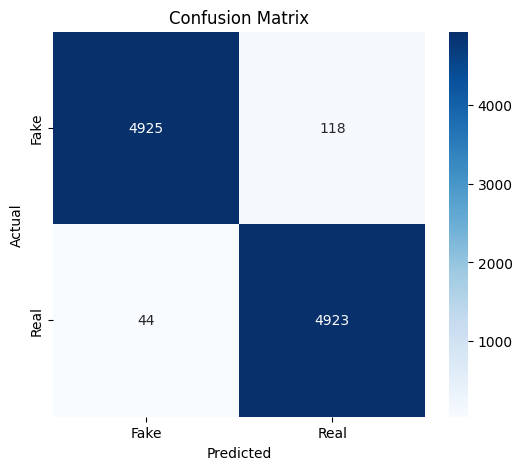


Classification Report:

              precision    recall  f1-score   support

        Fake       0.99      0.98      0.98      5043
        Real       0.98      0.99      0.98      4967

    accuracy                           0.98     10010
   macro avg       0.98      0.98      0.98     10010
weighted avg       0.98      0.98      0.98     10010



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Switch model to evaluation mode
model.eval()

# Lists to collect true and predicted labels
true_labels = []
pred_labels = []

# Disable gradient calculations
with torch.no_grad():
    # Loop through the test data
    for images, labels in test_loader:
        # Move images and labels to the specified device
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        outputs = model(images)
        # Get the predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Append the true and predicted labels to the lists
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)

# Print metrics
print(f"✅ Accuracy:  {accuracy * 100:.2f}%")
print(f"✅ Precision: {precision * 100:.2f}%")
print(f"✅ Recall:    {recall * 100:.2f}%")
print(f"✅ F1-score:  {f1 * 100:.2f}%")

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=['Fake', 'Real']))

In [ ]:
import torch
from torchvision import models
from torch import nn

# Load the ResNet-18 model architecture without pre-trained weights
model = models.resnet18(weights=None)
# Replace the final fully connected layer with a new one for binary classification
model.fc = nn.Linear(model.fc.in_features, 2)

# Define the path to the saved model
model_path = "/content/drive/MyDrive/face-classification-data/models/face_classifier_20250729_194456.pth"
# Load the saved model's state dictionary
model.load_state_dict(torch.load(model_path, map_location='cpu'))
# Set the model to evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from fastapi import FastAPI, UploadFile, File
from typing import List
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
import io

# Define the path to the saved model
model_path = "/content/drive/MyDrive/face-classification-data/models/face_classifier_20250729_194456.pth"

# Load model architecture
model = models.resnet18(weights=None)
# Replace the final fully connected layer with a new one for binary classification
model.fc = nn.Linear(model.fc.in_features, 2)

# Load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

#  Define transforms (should be the same as during training)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Important to match the training normalization
])

#  Prediction logic
def predict_images(model, images):
    """
    Predicts whether a list of images are real or fake.

    Args:
        model (torch.nn.Module): The trained model.
        images (list): A list of images as bytes.

    Returns:
        list: A list of predictions, where each prediction is either 'fake' or 'real'.
    """
    # Transform the images and stack them into a batch
    batch = torch.stack([
        transform(Image.open(io.BytesIO(img)).convert('RGB')) for img in images
    ])
    # Disable gradient calculations
    with torch.no_grad():
        # Forward pass
        outputs = model(batch.to(device))
        # Get the predicted labels
        _, preds = torch.max(outputs, 1)
    # Map predictions to labels
    class_names = ['fake', 'real']
    return [class_names[p] for p in preds.tolist()]

#  FastAPI app
app = FastAPI(title="Face Frame Classifier")

@app.post("/predict")
async def predict(files: List[UploadFile] = File(...)):
    """
    An endpoint to predict whether a list of uploaded images are real or fake.

    Args:
        files (List[UploadFile]): A list of uploaded image files.

    Returns:
        dict: A dictionary containing the predictions.
    """
    # Read the contents of the uploaded files
    contents = [await file.read() for file in files]
    # Get the predictions
    preds = predict_images(model, contents)
    # Return the predictions
    return {"predictions": preds}

In [ ]:
#Authentication token from ngrok
!ngrok config add-authtoken 30Vshk2e4jx68Twxqv1dYa1apm9_3CzTYsgVqDUwiXx7VTE6a

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# Install the pyngrok library, which is a Python wrapper for ngrok.
!pip install pyngrok

In [ ]:
# Import the ngrok library
from pyngrok import ngrok

In [ ]:
import nest_asyncio
from pyngrok import ngrok
import uvicorn

# Apply the nest_asyncio patch to allow the asyncio event loop to be nested.
# This is necessary to run uvicorn in a Jupyter/Colab environment.
nest_asyncio.apply()

# Open a public URL to the local port 8000 using ngrok
public_url = ngrok.connect(8000)
# Print the public URL
print(f"🚀 FastAPI running at: {public_url}/docs")

# Start the FastAPI application using uvicorn
uvicorn.run(app, host="0.0.0.0", port=8000)

🚀 FastAPI running at: NgrokTunnel: "https://0e2e5f1100d3.ngrok-free.app" -> "http://localhost:8000"/docs


INFO:     Started server process [606]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [606]


In [ ]:
# Mount Google Drive to the Colab environment.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to save the model
SAVE_PATH = '/content/drive/MyDrive/face-classification-data/models'
# Create the directory if it doesn't exist
os.makedirs(SAVE_PATH, exist_ok=True)

In [ ]:
import time
import os
import torch

# Define save path (e.g., your Google Drive folder)
SAVE_PATH = "/content/drive/MyDrive/face-classification-data/models"

# Generate timestamped filename
timestamp = time.strftime("%Y%m%d_%H%M%S")
MODEL_FILENAME = f"face_classifier_{timestamp}.pth"

# Save the model
torch.save(model.state_dict(), os.path.join(SAVE_PATH, MODEL_FILENAME))
print(f"✅ Model saved to: {os.path.join(SAVE_PATH, MODEL_FILENAME)}")

✅ Model saved to: /content/drive/MyDrive/face-classification-data/models/face_classifier_20250729_194456.pth


In [ ]:
import os

# Define the model path using the variables from the previous cell
model_path = os.path.join(SAVE_PATH, MODEL_FILENAME)

# Load the saved model's state dictionary
checkpoint = torch.load(model_path, map_location=device)
# Load the state dictionary into the model
missing, unexpected = model.load_state_dict(checkpoint, strict=False)
# Print a success message and any missing or unexpected keys
print("✅ Model loaded.")
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

✅ Model loaded.
Missing keys: []
Unexpected keys: []


# Real vs. Fake Face Classification with FastAPI

This project demonstrates how to build and deploy a deep learning model to classify images of faces as either "real" or "fake". The model is trained on a dataset of real and synthetically generated faces and then exposed as a web API using FastAPI and ngrok.

## Table of Contents

- [Project Overview](#project-overview)
- [Getting Started](#getting-started)
  - [Prerequisites](#prerequisites)
  - [Installation](#installation)
  - [Kaggle API Setup](#kaggle-api-setup)
- [Dataset](#dataset)
- [Model Training](#model-training)
  - [Custom CNN](#custom-cnn)
  - [ResNet-18 (Transfer Learning)](#resnet-18-transfer-learning)
- [Evaluation](#evaluation)
- [API Deployment](#api-deployment)
- [How to Use the API](#how-to-use-the-api)

## Project Overview

The main goal of this project is to create a reliable classifier for distinguishing between real human faces and those generated by AI (e.g., StyleGAN). The process involves:

1.  **Data Preparation**: Downloading and preparing the "140k Real and Fake Faces" dataset from Kaggle.
2.  **Model Training**: Training two different models: a custom Convolutional Neural Network (CNN) and a pre-trained ResNet-18 model using transfer learning.
3.  **Model Evaluation**: Evaluating the performance of the trained models using various metrics like accuracy, precision, recall, and a confusion matrix.
4.  **API Deployment**: Exposing the trained model as a web API using FastAPI, allowing for real-time predictions.
5.  **Public Access**: Using ngrok to create a public URL for the API, making it accessible from anywhere.

## Getting Started

### Prerequisites

*   Python 3.x
*   Jupyter Notebook or Google Colab
*   A Kaggle account and API token
*   An ngrok account and authentication token

### Installation

The necessary Python libraries can be installed by running the first cell of the notebook:

### ngrok Authentication

I have included my own ngrok authentication token in the notebook, so the API can be run without any additional setup.